# Insights from Failed Orders

*This data project has been used as a take-home assignment in the recruitment process for the data science positions at Gett.*

[Gett](https://www.gett.com/), previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

**Assignment**

Please complete the following tasks.

- Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?
- Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?
- Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?
- Plot the distribution of average ETA by hours. How can this plot be explained?
- **BONUS** Hexagons. Using the [h3](https://github.com/uber/h3-py) and [folium](https://python-visualization.github.io/folium/latest/) packages, calculate how many sizes [8 hexes](https://h3geo.org/#/documentation/core-library/resolution-table) contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

**Data Description**

We have two data sets: ``data_orders`` and ``data_offers``, both being stored in a CSV format. The ``data_orders`` data set contains the following columns:

- ``order_datetime`` - time of the order
- ``origin_longitude`` - longitude of the order
- ``origin_latitude`` - latitude of the order
- ``m_order_eta`` - time before order arrival
- ``order_gk`` - order number
- ``order_status_key`` - status, an enumeration consisting of the following mapping:
    - 4 - cancelled by client,
    - 9 - cancelled by system, i.e., a reject
``is_driver_assigned_key`` - whether a driver has been assigned
``cancellation_time_in_seconds`` - how many seconds passed before cancellation

The ``data_offers`` data set is a simple map with 2 columns:

- ``order_gk`` - order number, associated with the same column from the orders data set
- ``offer_id`` - ID of an offer

**Practicalities**

Make sure that the solution reflects your entire thought process including the preparation of data - it is more important how the code is structured rather than just the final result or plot.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
def first_looking(df, col):
    """
    Prints basic information about a column in a Pandas DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to analyze.
    col : str
        The name of the column to analyze.

    Returns:
    --------
    None.

    Prints:
    -------
    column name    : str
        The name of the column being analyzed.
    per_of_nulls   : float
        The percentage of null values in the column.
    num_of_nulls   : int
        The number of null values in the column.
    num_of_uniques : int
        The number of unique values in the column.
    shape_of_df    : tuple
        The shape of the DataFrame.
    The unique values in the column and their frequency of occurrence.
    """
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum() * 100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].astype(str).nunique())
    print("shape_of_df    : ", df.shape)
    print("--------------------------------")
    print(df[col].value_counts(dropna=False))

In [46]:
df1 = pd.read_csv('datasets/data_orders.csv')
df1.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [47]:
df1.shape

(10716, 8)

In [48]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [49]:
df1.isnull().sum()

order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
dtype: int64

In [50]:
df1.duplicated().sum()

0

In [51]:
df1.describe()

,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
count,10716.000000,10716.000000,2814.000000,1.071600e+04,10716.000000,10716.000000,7307.000000
mean,-0.964323,51.450541,441.415423,3.000598e+12,5.590612,0.262598,157.892021
std,0.022818,0.011984,288.006379,2.396261e+07,2.328845,0.440066,213.366963
min,-1.066957,51.399323,60.000000,3.000550e+12,4.000000,0.000000,3.000000
25%,-0.974363,51.444643,233.000000,3.000583e+12,4.000000,0.000000,45.000000
50%,-0.966386,51.451972,368.500000,3.000595e+12,4.000000,0.000000,98.000000
75%,-0.949605,51.456725,653.000000,3.000623e+12,9.000000,1.000000,187.500000
max,-0.867088,51.496169,1559.000000,3.000633e+12,9.000000,1.000000,4303.000000


In [52]:
df1.describe(include="object")

,order_datetime
count,10716
unique,9921
top,23:36:03
freq,4


In [53]:
df2 = pd.read_csv('datasets/data_offers.csv')
df2.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [54]:
df2.shape

(334363, 2)

In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


In [56]:
df2.isnull().sum()

order_gk    0
offer_id    0
dtype: int64

In [57]:
df2.duplicated().sum()

0

In [58]:
df2.describe()

,order_gk,offer_id
count,3.343630e+05,3.343630e+05
mean,3.000602e+12,3.000515e+11
std,2.431638e+07,5.276821e+05
min,3.000551e+12,3.000506e+11
25%,3.000585e+12,3.000511e+11
50%,3.000596e+12,3.000516e+11
75%,3.000625e+12,3.000520e+11
max,3.000633e+12,3.000524e+11


In [59]:
df1.order_gk.nunique()

10716

In [60]:
df2.order_gk.nunique()

97967

In [61]:
df1_order_gk_unique = df1.order_gk.unique().tolist()

In [62]:
df2_order_gk_unique = df2.order_gk.unique().tolist()

In [63]:
common_order_gk = list(set(df1_order_gk_unique) & set(df2_order_gk_unique))
len(common_order_gk)

7610

In [64]:
diff_order_gk = list(set(df1_order_gk_unique) ^ set(df1_order_gk_unique))
len(diff_order_gk)

0

In [65]:
diff_df1_order_gk_unique = list(set(df1_order_gk_unique) - set(df2_order_gk_unique))
len(diff_df1_order_gk_unique)

3106

In [66]:
diff_df2_order_gk_unique = list(set(df2_order_gk_unique) - set(df1_order_gk_unique))
len(diff_df2_order_gk_unique)

90357

In [67]:
df = pd.merge(df1, df2, how="inner", on=["order_gk"])
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275


In [68]:
df.columns

Index(['order_datetime', 'origin_longitude', 'origin_latitude', 'm_order_eta',
       'order_gk', 'order_status_key', 'is_driver_assigned_key',
       'cancellations_time_in_seconds', 'offer_id'],
      dtype='object')

In [69]:
df = df[['offer_id', 'order_gk', 'order_datetime', 'origin_longitude', 'origin_latitude',
       'm_order_eta', 'order_status_key', 'is_driver_assigned_key',
       'cancellations_time_in_seconds']]
df.head()

,offer_id,order_gk,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,300050983403,3000583041974,18:08:07,-0.978916,51.456173,60.0,4,1,198.0
1,300050986179,3000583116437,20:57:32,-0.950385,51.456843,NaN,4,0,128.0
2,300050986174,3000583116437,20:57:32,-0.950385,51.456843,NaN,4,0,128.0
3,300050986180,3000583116437,20:57:32,-0.950385,51.456843,NaN,4,0,128.0
4,300050976275,3000582891479,12:07:50,-0.969520,51.455544,477.0,4,1,46.0


In [70]:
df.shape

(31268, 9)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31268 entries, 0 to 31267
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   offer_id                       31268 non-null  int64  
 1   order_gk                       31268 non-null  int64  
 2   order_datetime                 31268 non-null  object 
 3   origin_longitude               31268 non-null  float64
 4   origin_latitude                31268 non-null  float64
 5   m_order_eta                    8364 non-null   float64
 6   order_status_key               31268 non-null  int64  
 7   is_driver_assigned_key         31268 non-null  int64  
 8   cancellations_time_in_seconds  21795 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 2.4+ MB


In [72]:
df.duplicated().sum()

0

In [73]:
df.describe()

,offer_id,order_gk,origin_longitude,origin_latitude,m_order_eta,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
count,3.126800e+04,3.126800e+04,31268.000000,31268.000000,8364.000000,31268.000000,31268.000000,21795.000000
mean,3.000515e+11,3.000600e+12,-0.964122,51.450594,473.206480,5.514807,0.267494,163.861803
std,4.752934e+05,2.308429e+07,0.020753,0.011311,285.080429,2.297730,0.442659,200.136770
min,3.000506e+11,3.000551e+12,-1.066957,51.399523,60.000000,4.000000,0.000000,3.000000
25%,3.000510e+11,3.000584e+12,-0.974268,51.444830,238.000000,4.000000,0.000000,56.000000
50%,3.000515e+11,3.000595e+12,-0.966529,51.452061,419.000000,4.000000,0.000000,106.000000
75%,3.000519e+11,3.000624e+12,-0.949786,51.456630,658.000000,9.000000,1.000000,195.000000
max,3.000524e+11,3.000633e+12,-0.875727,51.496169,1387.000000,9.000000,1.000000,4303.000000


In [74]:
df.describe(include="object")

,order_datetime
count,31268
unique,7183
top,23:36:03
freq,24


**offer_id**

ID of an offer

In [76]:
first_looking(df, 'offer_id')

column name    :  offer_id
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  31268
shape_of_df    :  (31268, 9)
--------------------------------
300050983403    1
300051335925    1
300051335985    1
300052141778    1
300052141714    1
               ..
300051177320    1
300051177266    1
300051177474    1
300051177235    1
300051391527    1
Name: offer_id, Length: 31268, dtype: int64


**order_gk**

order number

In [77]:
first_looking(df, 'order_gk')

column name    :  order_gk
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  7610
shape_of_df    :  (31268, 9)
--------------------------------
3000598136195    9
3000590506922    9
3000590107346    9
3000587781203    9
3000587906535    9
                ..
3000582466475    1
3000582441338    1
3000582115602    1
3000580176445    1
3000592871241    1
Name: order_gk, Length: 7610, dtype: int64


In [82]:
unique_elements, counts = np.unique(df.groupby('order_gk')['offer_id'].count().values, return_counts=True)

for element, count in zip(unique_elements, counts):
    print(f"Value: {element}, Count: {count}")

Value: 1, Count: 1461
Value: 2, Count: 914
Value: 3, Count: 1202
Value: 4, Count: 997
Value: 5, Count: 726
Value: 6, Count: 755
Value: 7, Count: 647
Value: 8, Count: 476
Value: 9, Count: 432


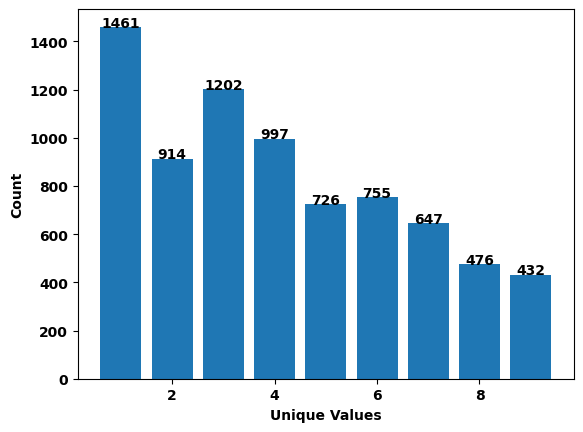

In [85]:
plt.bar(unique_elements, counts)
plt.xlabel('Unique Values')
plt.ylabel('Count')

for i, count in enumerate(counts):
    plt.text(unique_elements[i], count + 0.1, str(count), ha='center')
    
plt.show()

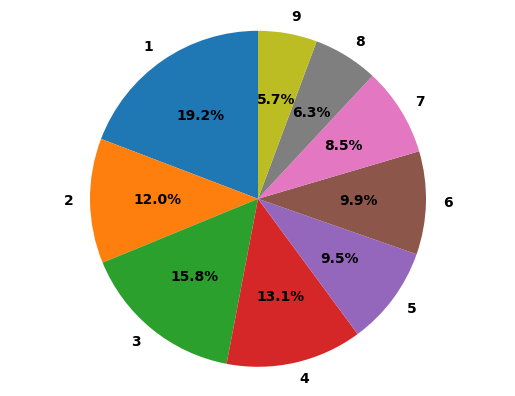

In [87]:
plt.pie(counts, labels=unique_elements, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

plt.show()